 **Step 1: Load the dataset directory from kaggle Using Api** 

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "latasaha" # username from the json file
os.environ['KAGGLE_KEY'] = "39622628149705a697b5ab6d9f7f4d6a" # key from the json file

In [ ]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [00:49<00:00, 164MB/s]
100% 7.25G/7.25G [00:49<00:00, 158MB/s]


In [ ]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/diabetic-retinopathy-resized.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
data = pd.read_csv("/content/trainLabels.csv")
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
data['image_name'] = [i+".jpeg" for i in data['image'].values]
data.head()

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

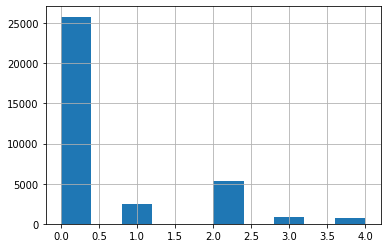

In [ ]:
data['level'].hist()
data['level'].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data, test_size=0.20, shuffle=True, random_state=42)
train, val = train_test_split(train, test_size=0.15, shuffle=True, random_state=42)

In [ ]:
train.shape, test.shape, val.shape

((23885, 3), (7026, 3), (4215, 3))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
def load_ben_color(image):
    IMG_SIZE = 224
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

In [ ]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.15,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=load_ben_color)

In [ ]:
# batch size
bs = 128

train_gen = data_gen.flow_from_dataframe(train, 
                                         "/content/resized_train/resized_train",
                                         x_col="image_name", y_col="level", class_mode="raw",
                                         batch_size=bs,
                                         target_size=(224, 224))
test_gen = data_gen.flow_from_dataframe(test,
                                       "/content/resized_train/resized_train",
                                       x_col="image_name", y_col="level", class_mode="raw",
                                       batch_size=bs,
                                       target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val,
                                       "/content/resized_train/resized_train",
                                       x_col="image_name", y_col="level", class_mode="raw",
                                       batch_size=bs,
                                       target_size=(224, 224))

Found 23885 validated image filenames.
Found 7026 validated image filenames.
Found 4215 validated image filenames.


In [ ]:
import tensorflow
from keras.applications.densenet import DenseNet121
from keras.applications.resnet_v2 import ResNet50V2
import keras.layers as L
from keras.models import Model

In [ ]:

base_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3),)
base_model.trainable = False

model = tensorflow.keras.models.Sequential()
model.add(base_model)
model.add(L.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(L.MaxPooling2D((3,3), strides=(3,3)))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())
model.add(L.Conv2D(32, (2,2), activation='relu', padding='same'))
model.add(L.MaxPooling2D((2,2), strides=(2,2), padding='same'))
model.add(L.Dropout(0.15))
model.add(L.Dense(512, activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dropout(0.2))
model.add(L.Dense(16, activation='relu'))
model.add(L.Dense(5, activation='softmax'))

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
op = Adam(learning_rate = 0.01, decay = 0.0001)
model.compile(optimizer=op, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          1179712   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          8

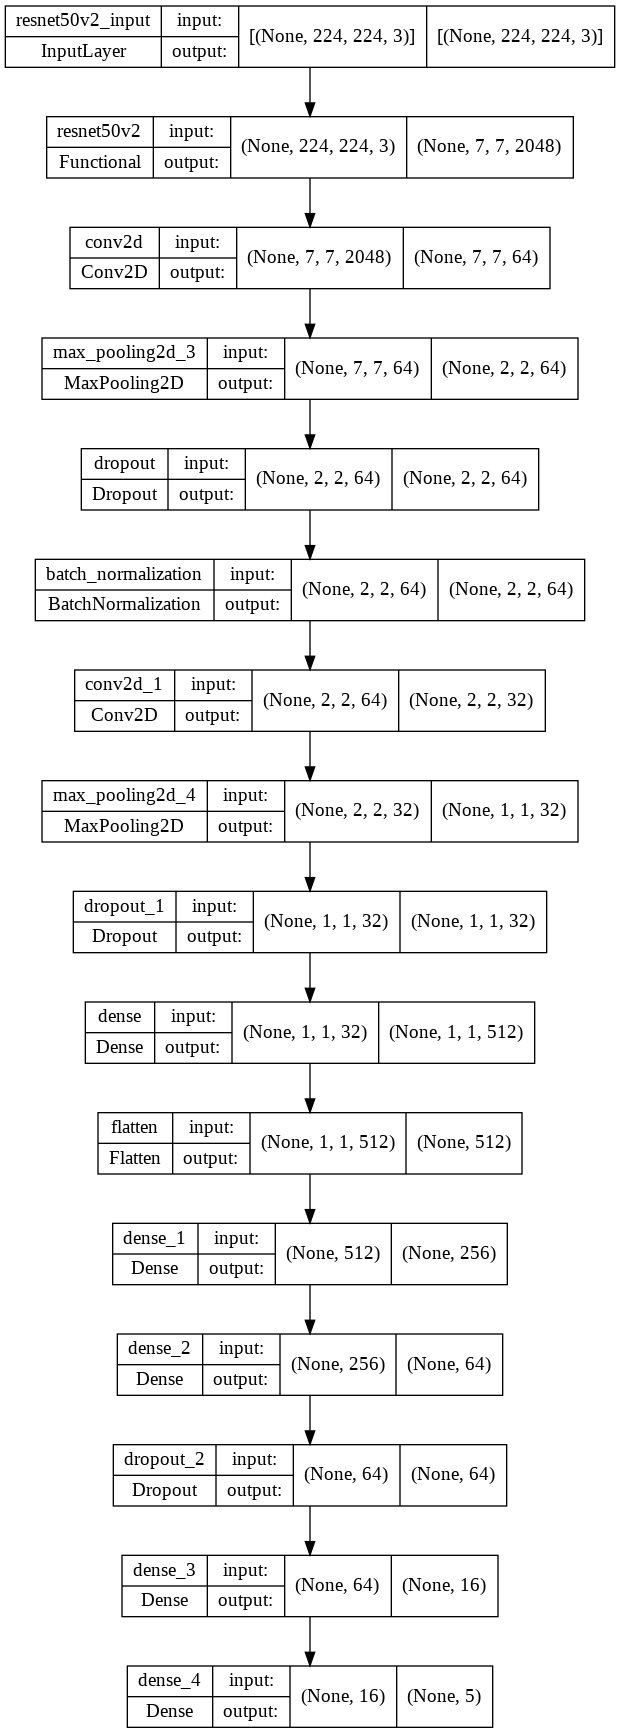

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='aug_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model_chk = ModelCheckpoint("best_model.h5", save_best_only=True, verbose = 2, monitor="val_accuracy")
# reduce_lr = ReduceLROnPlateau()

In [ ]:
history = model.fit(train_gen,
                    epochs=5,
                    verbose=1,
                    validation_data=val_gen,
                    callbacks = [model_chk]
                    )

Epoch 1/5
187/187 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.7266
Epoch 1: val_accuracy improved from -inf to 0.74638, saving model to best_model.h5
187/187 [==============================] - 621s 3s/step - loss: 0.8782 - accuracy: 0.7266 - val_loss: 0.7918 - val_accuracy: 0.7464
Epoch 2/5
187/187 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.7324
Epoch 2: val_accuracy did not improve from 0.74638
187/187 [==============================] - 568s 3s/step - loss: 0.8209 - accuracy: 0.7324 - val_loss: 0.7722 - val_accuracy: 0.7464
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.7320
Epoch 3: val_accuracy did not improve from 0.74638
187/187 [==============================] - 567s 3s/step - loss: 0.8118 - accuracy: 0.7320 - val_loss: 0.7733 - val_accuracy: 0.7464
Epoch 4/5
187/187 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.7331
Epoch 4: val_accuracy improved from 0.7

In [ ]:
from keras.models import load_model
model = load_model("best_model.h5")

In [ ]:
model.evaluate(test_gen, batch_size = bs, verbose=1)

55/55 [==============================] - 147s 3s/step - loss: 0.7775 - accuracy: 0.7395


[0.7775440216064453, 0.739538848400116]

In [ ]:
#Testing the model
from google.colab import files
uploaded = files.upload()

Saving 10_left.jpeg to 10_left.jpeg


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

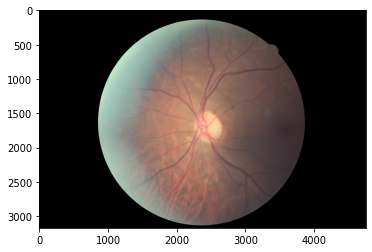

In [ ]:
#Showing image
uploaded_img = plt.imread('10_left.jpeg',0)
img = plt.imshow(uploaded_img)

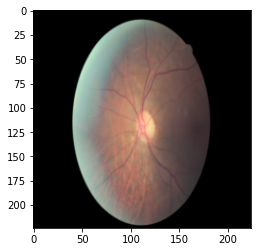

In [ ]:
#Resizing image
from skimage.transform import resize
resized_img = resize(uploaded_img, (224,224,3))
img = plt.imshow(resized_img)

In [ ]:
#Getting the models prediction
import numpy as np
pred = model.predict(np.array([resized_img]))

#Showing predictions
pred

array([[8.4541363e-01, 8.0234379e-02, 7.2901048e-02, 1.1571241e-03,
        2.9383623e-04]], dtype=float32)

In [ ]:
#Sorting predictions descending
list_index = [0,1,2,3,4]
x = pred

for i in range(5):
  for j in range(5):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp
  
#showing sorted label in order
#print the first 5 most likely classifications
for i in range(5):
  print(list_index[i], ':', pred[0][list_index[i]]*100, '%')

0 : 84.54136252403259 %
1 : 8.023437857627869 %
2 : 7.290104776620865 %
3 : 0.11571240611374378 %
4 : 0.02938362304121256 %
